<a href="https://colab.research.google.com/github/cawcawlabs/ouster_lidar_appnotes/blob/main/YOLOV5_OSX_IN_5MIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YOLOV5 + Ouster Lidar Object Detection Prototyping in 5 minutes

![picture](https://storage.googleapis.com/data.ouster.io/concept-engineering/colab_images/yolo_result.png)

As previously discussed on our Ouster blog post, having a high resolution, well formatted pixel array makes our lidar a hyperspectral camera, easily crossing the boundaries of what's possible in 2D *AND* 3D. <br>

In this post, we show an example of what it takes to graft a well known 2D deep learning network "Yolov5" to our 3D lidar scan result in less than 5 minutes.

We also provide bare minimum example code for anyone to start hacking.


# Setup

Download sample lidar pcap recording, install ouster-sdk and yolov5.

In [ ]:
%cd /content/

!wget https://data.ouster.io/sdk-samples/Rev-05/OS1-128_Rev-05_Urban-Drive/OS1-128_Rev-05_Urban-Drive.zip

!unzip /content/OS1-128_Rev-05_Urban-Drive.zip

!pip install 'ouster-sdk'

/content
--2022-04-02 23:05:35--  https://data.ouster.io/sdk-samples/Rev-05/OS1-128_Rev-05_Urban-Drive/OS1-128_Rev-05_Urban-Drive.zip
Resolving data.ouster.io (data.ouster.io)... 104.26.15.246, 172.67.72.60, 104.26.14.246, ...
Connecting to data.ouster.io (data.ouster.io)|104.26.15.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217491452 (207M) [application/zip]
Saving to: ‘OS1-128_Rev-05_Urban-Drive.zip’

OS1-128_Rev-05_Urba 100%[===================>] 207.42M  75.4MB/s    in 2.8s    

2022-04-02 23:05:38 (75.4 MB/s) - ‘OS1-128_Rev-05_Urban-Drive.zip’ saved [217491452/217491452]

Archive:  /content/OS1-128_Rev-05_Urban-Drive.zip
  inflating: OS1-128_Rev-05_Urban-Drive.json  
  inflating: OS1-128_Rev-05_Urban-Drive.pcap  
     |████████████████████████████████| 1.7 MB 5.2 MB/s 


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-85-g6f4eb95 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.4/78.2 GB disk)


##EXTRACTING LIDAR DATA FROM PCAP/JSON <br>
Based on Ouster Python SDK API doc https://static.ouster.dev/sdk-docs/quickstart.html <br> 
The "source" can be replaced with a live streaming sensor instead of pre-recorded .pcap. <br>
The json file describes the configuration of the sensor at the time of recording (10Hz/20Hz, destaggering parameters etc.) <br>
We'll now grab the 100th full frame scan out of the recording, extract the reflecitivy image for inspection.

In [ ]:
pcap_path = '/content/OS1-128_Rev-05_Urban-Drive.pcap'
metadata_path = '/content/OS1-128_Rev-05_Urban-Drive.json'

from ouster import client
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#Process metadata from 
with open(metadata_path, 'r') as f:
    info = client.SensorInfo(f.read())

from ouster import pcap
source = pcap.Pcap(pcap_path, info)

from contextlib import closing
from more_itertools import nth
with closing(client.Scans(source)) as scans:
    scan = nth(scans, 100)

#range
range_field = scan.field(client.ChanField.RANGE)
range_img = client.destagger(info, range_field)

#reflectivity
ref_field = scan.field(client.ChanField.REFLECTIVITY)
ref_val = client.destagger(info, ref_field)
#ref_img = (ref_val / np.max(ref_val) * 255).astype(np.uint8) #how SDK example does scaling for visualization
ref_img = ref_val.astype(np.uint8)

combined_img = np.dstack((ref_img, ref_img, ref_img))

##LET'S INSPECT THE SCAN IMAGE

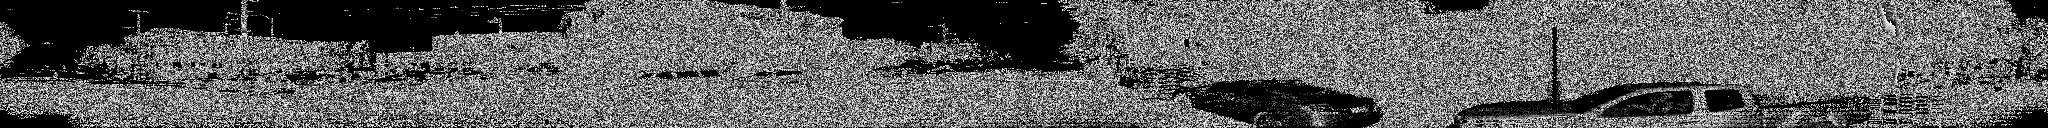

In [ ]:
cv2_imshow(ref_img[:, :])

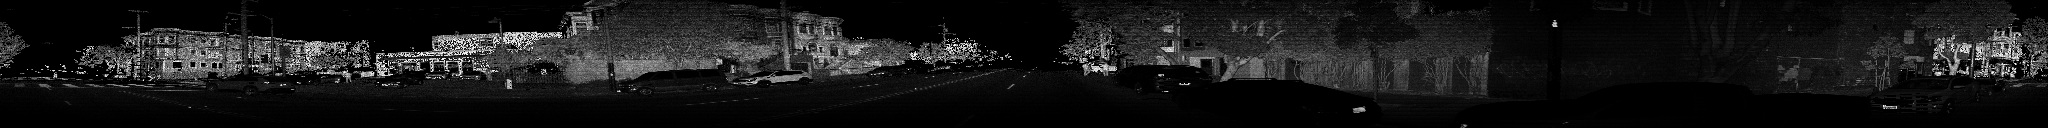

In [ ]:
ref_img_sdk = (ref_val / np.max(ref_val) * 255).astype(np.uint8) #how SDK example does scaling for visualization
cv2_imshow(ref_img_sdk)

The raw 16 bit field reflectivity data "ref_val" histogram looks like this (histogram code at the appendix section). <br>

If we clip and normalize at 255, a lot of useful data would collapsed in the lower intensity bin before even attempting the inference.

![picture](https://storage.googleapis.com/data.ouster.io/concept-engineering/colab_images/100thscan_ref_distribution.png
)

<br>
For the calbrated reflectivity version, lower 8 bit is used, 0-255. 0-100 for 0-100% reflective lambertian targets, 101 ~ 255 for log scale range of retro-reflectors.


##PROCESS LIDAR DATA, FEED TO YOLOv5


Obviously, the raw image "ref_val" is not suitable for yolov5's digestion.
The reflectivity data range is big (0 to 10k), and it's greyscale. <br>

We need to massage the data to replicate the 0-255 range of the yolov5 network input while preserving the reflectivity contrast as much as possible. <br>

The model pre-processor will also take the uint255 image and do it's own pre-processing to get to 0~1 float vector before the inference, but it's handled by yolov5 side (compare against "detect.py" for more insights).<br>

Let's try using a larger model, apply gamma correction to the reflectivity field, and stack 3 spreads spoofing as RGB channel.

In [ ]:
# model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/best.pt')  # if you are using custom model as our recent blogpost!
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-85-g6f4eb95 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)



  0%|          | 0.00/270M [00:00<?, ?B/s]

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients, 209.8 GFLOPs
Adding AutoShape... 


[   0  500 1000 1500 2000]
         xmin       ymin        xmax       ymax  confidence  class name
0  204.706543  71.925674  296.179565  96.106567    0.593146      2  car
1  456.054779  70.574097  486.052307  80.782768    0.357150      2  car
2  376.224091  75.298378  408.943848  88.604965    0.342854      2  car
3  287.939697  70.514877  320.118805  84.869568    0.296193      2  car
4  425.062225  71.183968  448.587280  79.748741    0.295830      2  car
5  318.840332  70.980354  346.411926  84.169945    0.255919      2  car
         xmin       ymin        xmax       ymax  confidence  class name
0  255.142563  69.055244  312.850464  87.337265    0.680296      2  car
1  116.926231  68.278442  225.927551  97.081947    0.632285      2  car
2   26.207088  60.625713   59.501762  74.934669    0.303547      2  car
         xmin        ymin        xmax        ymax  confidence  class name
0  115.755295   64.412636  212.937637   95.636322    0.760308      2  car
1  165.104065   77.948563  382.67

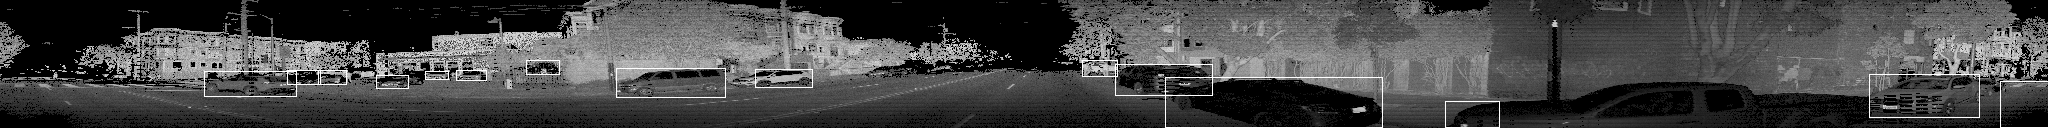

In [ ]:
def gammaCorrection(src,gamma): #modified to return 0-255
   invGamma = 1/gamma
   return (src**invGamma)*255

signal  = client.destagger(info,scan.field(client.ChanField.REFLECTIVITY))
step_size = 500 #The scan image is 2048x128. If you don't make it into a digestable size, the aspect ratio of objects will be squashed when yolov5 scales it to 640x640 and vectorzies it

split_lines = np.arange(0,2048,step_size)

print(split_lines)
images = np.split(signal,split_lines[1:],axis=1)
images[-1] = signal[:,-step_size:]

#now gamma correct and then feed the "image" to inference

#signal = (signal / np.max(signal)*255).astype(np.uint8) #signal is a copy just for visualization. 
signal = np.clip(signal,0,100000) #(100k, 0.5)
signal = (signal/100000)
signal = gammaCorrection(signal,3).astype(np.uint8) #gamma corrected version looks better than default sdk example of 255 normalizing

for raw_img, lines in zip(images, split_lines):
    raw_img = np.clip(raw_img,0,100000) #(100k, 1.3)
    raw_img = (raw_img/100000) #if we clipped and normalized at 255, a lot of useful data would have been collapsed in the lower intensity bin before even attempting the gamma correction.
    gamma_img_r = gammaCorrection(raw_img, 1.5).astype(np.uint8) #1.5
    gamma_img_g = gammaCorrection(raw_img, 1.1).astype(np.uint8) #1.1
    gamma_img_b = gammaCorrection(raw_img, 0.5).astype(np.uint8) #0.5
    #RGB gamma with spread out gamma values to spoof rgb -> v5x6 100k 1.5,1.1,0.5, 512 setp size    

    combined_img = np.stack([gamma_img_r,gamma_img_g,gamma_img_b], axis=2) #this can be any hyperspectral image for experimentation. Play around to see what works and doesn't

    results = model(combined_img) #normally expects 640x640 RGB (0-255) that preserves good brightness correction.
    obj_table = results.pandas().xyxy[0]
    print(obj_table)
    #'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'  # xyxy columns
    #now stitch inference results to larger 2048x128
    for index, row in obj_table.iterrows():
        tl_corner = (int(row['xmin'])+lines,int(row['ymax']))
        br_corner = (int(row['xmax'])+lines,int(row['ymin']))
        cv2.rectangle(signal, tl_corner, br_corner, (255,255,255),1) #white box, line width 1

#cv2_imshow(gammaCorrection(signal, 1.5).astype(np.uint8))
cv2_imshow(signal)


Much better, and all this with a single lidar scan + yolov5 in 5min!

![picture](https://storage.googleapis.com/data.ouster.io/concept-engineering/colab_images/yolo_result.png)

Let's reflect on this:

1. Since our 2D reflectivity image perfectly corresponds to our depth image, you can easily grab distance information from your detected objects without any further processing. See "range_img" showing depth per pixel below.

2. You've effectively increased the range of classifiable objects from car/pedestrians/bicycles typical in 3D only algos to 91 classes ranging from "hair brush" to "cow" offered by COCO dataset. Wth this code, you can now count cows/bears/giraffes/horses/dogs/elephants! (Sorry, no lions or tigers)

3. 2D deep learning networks are way more readily deployable for edge computing versus many great 3D point cloud based object detection methods that require multiple levels of networks (Pointpillars require at least 2 network stages imported). Race you to porting this to Jetson Nano!

Ouster OSx sensors are cool hyperspectral cameras!


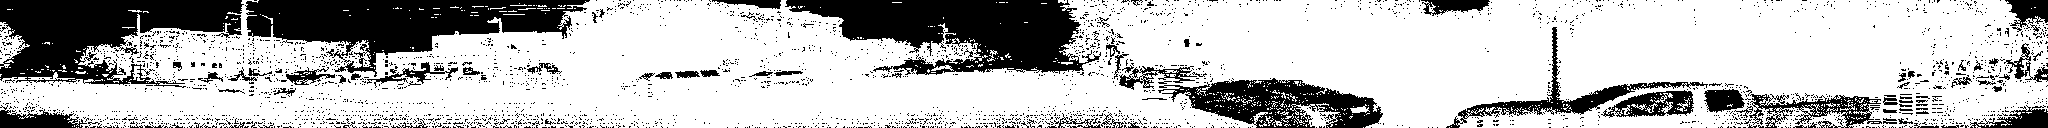

In [ ]:
cv2_imshow(range_img[:, 0:2048])

##APPENDIX

Technical commentaries:
 
1.   Since we are chopping a long image (2048x128) to small 500x128 images, Few of these subimages can have objects in a non-ideal location for detection, chopped in half for each subimages (checkout that stretched truck on the right). We'll have to overcome this by re-training/augmenting yolov5 to accept bigger images.
2.   If we don't chop the image into the model's trained size, the aspect ratio inormation will be distorted in yolov5's pre-processing, and only the objects that are big enough to survive the distortion will be detected, essentially shortening the detectable range of yolov5 + OSx solution. 
3. There's a lot of work being done on how to convert 2D bounding boxes to 3D bounding boxes. It's an underconstrained problem and no plug and play solutions seem to be around circa 2022. 






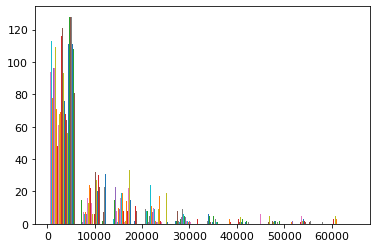

In [ ]:

import matplotlib.pyplot as plt 

plt.hist(ref_val, bins=10)

plt.show()